<a href="https://colab.research.google.com/github/quynhu-d/kws/blob/main/KWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and misc

In [2]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 831.4 MB 7.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [3]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [5]:
#!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf /content/drive/MyDrive/Colab\ Notebooks/DLA/KWS/speech_commands_v0.01.tar.gz 1> log

In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [15]:
dataset.csv.sample(5)

,path,keyword,label
50905,speech_commands/no/8523766b_nohash_1.wav,no,0
9698,speech_commands/zero/7b301939_nohash_1.wav,zero,0
1693,speech_commands/on/29fb33da_nohash_2.wav,on,0
6840,speech_commands/four/b1f8326d_nohash_0.wav,four,0
19276,speech_commands/yes/3ae5c04f_nohash_1.wav,yes,0


### Augmentations

In [16]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [17]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [46]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')

In [18]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [19]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [20]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [21]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [22]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [23]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [24]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [53]:
# melspec_train(next(iter(train_loader))[0].to('cuda')).shape

torch.Size([128, 40, 101])

### Quality measurement functions:

In [25]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [26]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [27]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [28]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [29]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [30]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [31]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [32]:
sum([p.numel() for p in model.parameters()])

70443

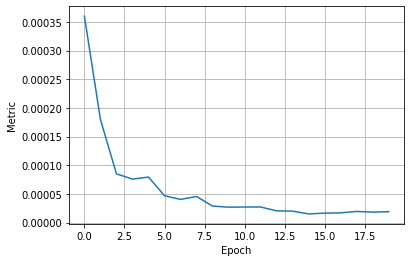

END OF EPOCH 19


In [38]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [39]:
history

defaultdict(list,
            {'val_metric': [0.0003598132814037343,
              0.0001798022086191975,
              8.506739076889015e-05,
              7.583559466089485e-05,
              7.941015566198676e-05,
              4.6833313416643275e-05,
              4.044206995726192e-05,
              4.555625823428323e-05,
              2.8859060102304646e-05,
              2.690767204327785e-05,
              2.7176211684428326e-05,
              2.723588716023954e-05,
              2.050449348873424e-05,
              1.999725194433889e-05,
              1.5157570856049174e-05,
              1.6506236609382685e-05,
              1.7013478153778034e-05,
              1.9454205114456816e-05,
              1.82965008837192e-05,
              1.9027525462406615e-05]})

In [40]:
torch.save(model.state_dict(), 'base_model')
torch.save(opt.state_dict(), 'base_opt')

# Utils

In [114]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [33]:
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [41]:
!pip install thop

In [ ]:
melspec_train(iter(train_loader).next()[0].to(config.device)).shape

torch.Size([128, 40, 101])

In [42]:
from thop import profile        
profile(CRNN(config), (torch.randn(128, 40, 101), ))  # -> (6.0 MACs, 3.0 parameters)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(119527424.0, 70443.0)

In [43]:
def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)

get_size_in_megabytes(model)

0.2687187194824219

# Streaming

In [ ]:
class StreamingCRNN(CRNN):
    def __init__(self, config, max_window_length):
        self.max_window_length = max_window_length
        super().__init__(config)
    
    def forward(self, input):
        pass

# Dark Knowledge Distillation

In [131]:
def train_epoch_w_teacher(student, teacher, opt, loader, log_melspec, device, temp=20, alpha=.5):
    student.train()
    teacher.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        teacher_logits = teacher(batch).detach()
        student_logits = student(batch)

        soft_labels = F.softmax(teacher_logits / temp, dim=-1)
        soft_preds = F.softmax(student_logits / temp, dim=-1)
        distill_loss = F.kl_div(soft_preds.log(), soft_labels, reduction='sum')    # KL divergence

        hard_probs = F.softmax(student_logits, dim=-1)
        student_loss = F.cross_entropy(student_logits, labels)

        loss = alpha * student_loss + (1 - alpha) * distill_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(hard_probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train_w_teacher(student, teacher, config, opt, loaders, log_melspec, temp=20, alpha=.5):
    train_loader, val_loader = loaders
    melspec_train, melspec_val = log_melspec
    history = defaultdict(list)
    for n in range(config.num_epochs):

        train_epoch_w_teacher(
            student, teacher, opt, train_loader, melspec_train, config.device, temp, alpha
        )

        au_fa_fr = validation(student, val_loader, melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH %d / %d' % (n, config.num_epochs))
        
        if (au_fa_fr - 1.1 * 5e-5) <= 5e-6:
            break
    return history

In [113]:
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [132]:
student_config = TaskConfig
student_config.hidden_size = 16
student_config.cnn_out_channels = 4
student_config.num_epochs = 50

student_model = CRNN(student_config).to(student_config.device)
student_opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
print('Number of params %d' % count_parameters(student_model))
student_model

Number of params 6679


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

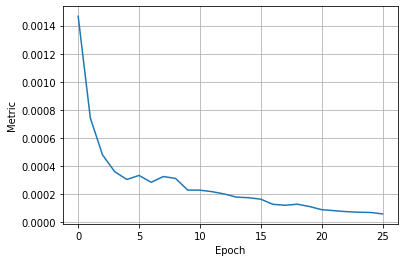

END OF EPOCH 25 / 50


In [133]:
res_distill = train_w_teacher(student_model, model, student_config, student_opt, 
                (train_loader, val_loader), (melspec_train, melspec_val))

In [135]:
res_distill['val_metric'][-1]

5.731531074288358e-05

In [149]:
model.eval()
with Timer('Base model', verbose=True):
    model(melspec_val(next(iter(val_loader))[0].to(config.device)))

Base model | Elapsed time : 0.48


In [145]:
student_model.eval()
with Timer('Student model', verbose=True):
    student_model(melspec_val(next(iter(val_loader))[0].to(config.device)))

Student model | Elapsed time : 0.41


In [153]:
torch.save(student_model.state_dict(), 'student_model_1')
torch.save(student_opt.state_dict(), 'student_opt_1')

In [161]:
base_macs, base_n_params = profile(CRNN(config), (torch.randn(1,40,101),))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [162]:
student_macs, student_n_params = profile(CRNN(student_config), (torch.randn(1, 40, 101),))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [163]:
base_mb_sz = get_size_in_megabytes(model)
print(base_mb_sz)
student_mb_sz = get_size_in_megabytes(student_model)
print(student_mb_sz)

0.2687187194824219
0.025478363037109375


In [228]:
def config_to_dict(config, hparam_n = 15):
    return {key: config.__dict__[key] for key in sorted(config.__dict__.keys())[-hparam_n:]}
config_to_dict(config)

{'batch_size': 128,
 'bidirectional': False,
 'cnn_out_channels': 8,
 'device': device(type='cuda', index=0),
 'gru_num_layers': 2,
 'hidden_size': 64,
 'kernel_size': (5, 20),
 'keyword': 'sheila',
 'learning_rate': 0.0003,
 'n_mels': 40,
 'num_classes': 2,
 'num_epochs': 20,
 'sample_rate': 16000,
 'stride': (2, 8),
 'weight_decay': 1e-05}

In [247]:
import pandas as pd
results_df = pd.DataFrame(columns=['SETTING', 'MACS', 'MB_SZ', 'N_PARAMS', 'METRIC'])
results_df = results_df.append(
    {
        **{
        'SETTING': 'Base model', 
        'MACS': base_macs, 'MB_SZ': base_mb_sz, 'N_PARAMS': base_n_params, 
        'METRIC': history['val_metric'][-1]
        },
        **config_to_dict(config)
    }, 
    ignore_index=True)
results_df

,SETTING,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,Base model,933808.0,0.268719,70443.0,0.000019,128.0,0.0,8.0,cuda:0,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001


In [248]:
results_df = results_df.append(
    {
        **{
            'SETTING': 'Dark Knowledge Distillation',
            'MACS': student_macs, 'MB_SZ': student_mb_sz, 'N_PARAMS': student_n_params, 
            'METRIC': res_distill['val_metric'][-1]
        },
        **config_to_dict(student_config) 
    },
    ignore_index=True)
results_df

,SETTING,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,Base model,933808.0,0.268719,70443.0,0.000019,128.0,0.0,8.0,cuda:0,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001
1,Dark Knowledge Distillation,150952.0,0.025478,6679.0,0.000057,128.0,0.0,4.0,cuda:0,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001


In [249]:
results_df.to_csv('drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', index=False)

In [250]:
pd.read_csv('drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv')

,SETTING,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,Base model,933808.0,0.268719,70443.0,0.000019,128.0,0.0,8.0,cuda:0,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001
1,Dark Knowledge Distillation,150952.0,0.025478,6679.0,0.000057,128.0,0.0,4.0,cuda:0,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001
